# Battle Of The Neighborhoods (The)

## Introduction: Business Problem <a name="introduction"></a>

For this last assignment we'll try to find a good location to open a **Coffee Shop** in Miami, Florida. The first premise for this shop is that this is going to be a place to relax. Secondly, a coffe shop is not a place where people use to stay for a long time.

The criteria to pick a location are two. First we want a neighborhood with not many coffee shops. Also we want a neighborhood as crowded and active as possible -so we can offer people a small quiet oasis to relax.

In this project we are using open source data from 2010. This set of data has not only the Miami neighborhoods population, it also contains the population density. We will use **Fourdquare API** to take a look on the most common venues in the analyzed neighborhoods. The neighborhoods are then clustered using **k-means**.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing coffee shops in the neighborhood
* population density in the neighborhood

The neighborhoods are clustered on base of their venues

* the processed dataset is initially crossed with Foursquare's database to take a look on the most common venues in the analyzed neighborhoods.
* we are clustering the neighborhoods using **k-means** and the **Elbow Method** to obtain the optimal *k*.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# !conda install -c conda-forge lxml --yes

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt # for we're gonna plot something and aproach some value for k

print('Libraries imported.')

Libraries imported.


#### First we obtain the data and pass it into a dataframe:

In [2]:
link = "https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami"

df1 = pd.read_html(link)[0]
df1.to_csv('wikipedia.csv',header=0,index=False)
df1.shape

(26, 6)

In [3]:
df1.head()

,Neighborhood,Demonym,Population2010,Population/Km²,Sub-neighborhoods,Coordinates
0,Allapattah,NaN,54289,4401,NaN,25.815-80.224
1,Arts & Entertainment District,NaN,11033,7948,NaN,25.799-80.190
2,Brickell,Brickellite,31759,14541,West Brickell,25.758-80.193
3,Buena Vista,NaN,9058,3540,Buena Vista East Historic District and Design ...,25.813-80.192
4,Coconut Grove,Grovite,20076,3091,"Center Grove, Northeast Coconut Grove, Southwe...",25.712-80.257


The coordinates are wrong so we're gonna fix it

In [4]:
coordf = df1['Coordinates'].str.split('-', 1, expand=True)  # we split the 'coordinates' column (we're ommitng the minus sign for the moment)
print(coordf.dtypes)  # we'll see it is an object and we need a float type
coordf.columns = ['Latitude', 'Longitude']
coordf.head()

0    object
1    object
dtype: object


,Latitude,Longitude
0,25.815,80.224
1,25.799,80.190
2,25.758,80.193
3,25.813,80.192
4,25.712,80.257


In [5]:
coordf = coordf.apply(pd.to_numeric) # convert all columns of DataFrame
coordf['Longitude'] = -1*coordf['Longitude'] # now we correct the minus sign
print(coordf.dtypes)
coordf.head()

Latitude     float64
Longitude    float64
dtype: object


,Latitude,Longitude
0,25.815,-80.224
1,25.799,-80.190
2,25.758,-80.193
3,25.813,-80.192
4,25.712,-80.257


Now we can define our Florida dataframe

In [6]:
# miamidf = pd.DataFrame(columns=['Neighborhood','Latitude', 'Longitude'])
miamidf = pd.DataFrame(columns=['Neighborhood', 'Population (2010)', 'Population per Km²', 'Latitude', 'Longitude'])
miamidf['Neighborhood'] = df1['Neighborhood']
miamidf['Population (2010)'] = df1['Population2010']
miamidf['Population per Km²'] = df1[df1.columns[3]]
miamidf['Latitude'] = coordf['Latitude']
miamidf['Longitude'] = coordf['Longitude']
miamidf.shape
miamidf  # we can see it has some NaN rows wich we're gonna eliminate

,Neighborhood,Population (2010),Population per Km²,Latitude,Longitude
0,Allapattah,54289,4401,25.815,-80.224
1,Arts & Entertainment District,11033,7948,25.799,-80.190
2,Brickell,31759,14541,25.758,-80.193
3,Buena Vista,9058,3540,25.813,-80.192
4,Coconut Grove,20076,3091,25.712,-80.257
5,Coral Way,35062,4496,25.750,-80.283
6,Design District,3573,3623,25.813,-80.193
7,Downtown,"71,000 (13,635 CBD only)",10613,25.774,-80.193
8,Edgewater,15005,6675,25.802,-80.190
9,Flagami,50834,5665,25.762,-80.316


In [7]:
miamidf = miamidf[pd.notnull(miamidf['Latitude'])]
miamidf = miamidf.reset_index(drop=True)
miamidf

,Neighborhood,Population (2010),Population per Km²,Latitude,Longitude
0,Allapattah,54289,4401,25.815,-80.224
1,Arts & Entertainment District,11033,7948,25.799,-80.190
2,Brickell,31759,14541,25.758,-80.193
3,Buena Vista,9058,3540,25.813,-80.192
4,Coconut Grove,20076,3091,25.712,-80.257
5,Coral Way,35062,4496,25.750,-80.283
6,Design District,3573,3623,25.813,-80.193
7,Downtown,"71,000 (13,635 CBD only)",10613,25.774,-80.193
8,Edgewater,15005,6675,25.802,-80.190
9,Flagami,50834,5665,25.762,-80.316


Let's get the geographical coordinates of Miami:

In [8]:
address = 'Miami, FL'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Miami are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Miami are 25.7742658, -80.1936589.


In [9]:
# create map of Miami using latitude and longitude values
map_miami = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(miamidf['Latitude'], miamidf['Longitude'], miamidf['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_miami)  
    
map_miami

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [10]:
CLIENT_ID = 'ZWQUMHDSAMIRZ21JCYEKKAUPJV4BFJDI5YEVGJJDDC4EZLG3' # your Foursquare ID
CLIENT_SECRET = 'HPTKUUZDFRHLWAFCVZVV203FTRD5GWSIZDHA3JR1IPXCZBXF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZWQUMHDSAMIRZ21JCYEKKAUPJV4BFJDI5YEVGJJDDC4EZLG3
CLIENT_SECRET:HPTKUUZDFRHLWAFCVZVV203FTRD5GWSIZDHA3JR1IPXCZBXF


<a id='item2'></a>

## 2. Explore Neighborhoods in Miami

#### Let's create a function to repeat the same process to all the neighborhoods in Miami

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now we write the code to run the above function on each neighborhood and create a new dataframe called *miamidf*.

In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

miami_venues = getNearbyVenues(names=miamidf['Neighborhood'],
                                   latitudes=miamidf['Latitude'],
                                   longitudes=miamidf['Longitude']
                                  )

Allapattah
Arts & Entertainment District
Brickell
Buena Vista
Coconut Grove
Coral Way
Design District
Downtown
Edgewater
Flagami
Grapeland Heights
Liberty City
Little Haiti
Little Havana
Lummus Park
Midtown
Overtown
Park West
The Roads
Upper Eastside
Venetian Islands
Virginia Key
West Flagler
Wynwood


#### Let's find out how many unique categories can be curated from all the returned venues

In [13]:
print('There are {} uniques categories.'.format(len(miami_venues['Venue Category'].unique())))

There are 138 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [14]:
# one hot encoding
miami_onehot = pd.get_dummies(miami_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
miami_onehot['Neighborhood'] = miami_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [miami_onehot.columns[-1]] + list(miami_onehot.columns[:-1])
miami_onehot = miami_onehot[fixed_columns]

miami_onehot.head()

,Yoga Studio,Accessories Store,American Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Beach,Big Box Store,Bistro,Boat or Ferry,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Empanada Restaurant,Event Space,Fast Food Restaurant,Fish Market,Flea Market,Food,Food Truck,French Restaurant,Furniture / Home Store,Gas Station,Gastropub,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,Home Service,Hotel,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Latin American Restaurant,Lawyer,Leather Goods Store,Liquor Store,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mobile Phone Shop,Motel,Moving Target,Museum,Neighborhood,New American Restaurant,Nightclub,Optical Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Theater,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wine Bar,Wine Shop,Winery,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Allapattah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Allapattah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Allapattah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Allapattah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Arts & Entertainment District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [15]:
miami_onehot.shape

(488, 138)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [16]:
miami_grouped = miami_onehot.groupby('Neighborhood').mean().reset_index()
miami_grouped

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Beach,Big Box Store,Bistro,Boat or Ferry,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Empanada Restaurant,Event Space,Fast Food Restaurant,Fish Market,Flea Market,Food,Food Truck,French Restaurant,Furniture / Home Store,Gas Station,Gastropub,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,Home Service,Hotel,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Latin American Restaurant,Lawyer,Leather Goods Store,Liquor Store,Lounge,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mobile Phone Shop,Motel,Moving Target,Museum,New American Restaurant,Nightclub,Optical Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Theater,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wine Bar,Wine Shop,Winery,Wings Joint
0,Allapattah,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.00000,0.0000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.250000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Arts & Entertainment District,0.052632,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000,0.000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.00000,0.0000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.052632,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.105263,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.052632,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.052632,0.000000,0.000000,0.000000,0.0000,0.052632,0.052632,0.000000,0.000000,0.000000,0.0

#### Let's confirm the new size

In [17]:
miami_grouped.shape

(24, 138)

#### Let's print each neighborhood along with the top 5 most common venues

In [18]:
num_top_venues = 5

for hood in miami_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = miami_grouped[miami_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allapattah----
               venue  freq
0         Boxing Gym  0.25
1   Department Store  0.25
2  Convenience Store  0.25
3             Lounge  0.25
4               Park  0.00


----Arts & Entertainment District----
            venue  freq
0      Restaurant  0.16
1             Gym  0.11
2     Yoga Studio  0.05
3             Spa  0.05
4  Ice Cream Shop  0.05


----Brickell----
                 venue  freq
0                Hotel  0.08
1   Italian Restaurant  0.07
2                 Café  0.05
3  Japanese Restaurant  0.05
4               Lounge  0.03


----Buena Vista----
                venue  freq
0       Jewelry Store  0.08
1                Café  0.08
2  Italian Restaurant  0.08
3            Boutique  0.08
4   Indian Restaurant  0.04


----Coconut Grove----
                           venue  freq
0                           Park  0.33
1            American Restaurant  0.33
2                  Boat or Ferry  0.33
3  Paper / Office Supplies Store  0.00
4                          Motel 

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = miami_grouped['Neighborhood']

for ind in np.arange(miami_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(miami_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allapattah,Convenience Store,Boxing Gym,Department Store,Lounge,Donut Shop,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Dog Run
1,Arts & Entertainment District,Restaurant,Gym,Spa,Ice Cream Shop,Food Truck,Moving Target,Cupcake Shop,Paper / Office Supplies Store,Park,Coffee Shop
2,Brickell,Hotel,Italian Restaurant,Café,Japanese Restaurant,Juice Bar,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Bar,Bank
3,Buena Vista,Café,Italian Restaurant,Boutique,Jewelry Store,American Restaurant,Indian Restaurant,Shopping Mall,Big Box Store,Clothing Store,Wine Bar
4,Coconut Grove,Boat or Ferry,American Restaurant,Park,Dog Run,Flea Market,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Donut Shop


## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood and let's find a good value for k

In [21]:
miami_grouped_clustering = miami_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1,24)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(miami_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

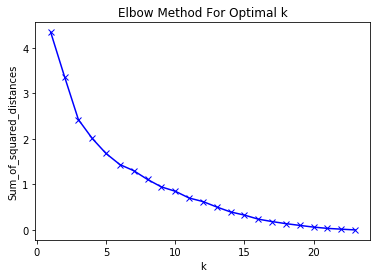

In [22]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
#Sum_of_squared_distances

Let's then take k = 8.

In [23]:
# set number of clusters
kclusters = 8

# miami_grouped_clustering = miami_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(miami_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 4, 1, 1, 1, 1, 6], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

miami_merged = miamidf

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
miami_merged = miami_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

miami_merged #.head() # check the last columns!

,Neighborhood,Population (2010),Population per Km²,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allapattah,54289,4401,25.815,-80.224,0,Convenience Store,Boxing Gym,Department Store,Lounge,Donut Shop,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Dog Run
1,Arts & Entertainment District,11033,7948,25.799,-80.190,1,Restaurant,Gym,Spa,Ice Cream Shop,Food Truck,Moving Target,Cupcake Shop,Paper / Office Supplies Store,Park,Coffee Shop
2,Brickell,31759,14541,25.758,-80.193,1,Hotel,Italian Restaurant,Café,Japanese Restaurant,Juice Bar,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Bar,Bank
3,Buena Vista,9058,3540,25.813,-80.192,1,Café,Italian Restaurant,Boutique,Jewelry Store,American Restaurant,Indian Restaurant,Shopping Mall,Big Box Store,Clothing Store,Wine Bar
4,Coconut Grove,20076,3091,25.712,-80.257,4,Boat or Ferry,American Restaurant,Park,Dog Run,Flea Market,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Donut Shop
5,Coral Way,35062,4496,25.750,-80.283,1,Liquor Store,Pharmacy,Golf Course,Mobile Phone Shop,Burger Joint,Café,Dive Bar,Seafood Restaurant,Historic Site,Diner
6,Design District,3573,3623,25.813,-80.193,1,Café,Italian Restaurant,Boutique,Jewelry Store,American Restaurant,Indian Restaurant,Shopping Mall,Big Box Store,Clothing Store,Wine Bar
7,Downtown,"71,000 (13,635 CBD only)",10613,25.774,-80.193,1,Peruvian Restaurant,Hotel,Café,Italian Restaurant,Pharmacy,Coffee Shop,Brazilian Restaurant,Cosmetics Shop,Gym,Salon / Barbershop
8,Edgewater,15005,6675,25.802,-80.190,1,Restaurant,Sandwich Place,Ice Cream Shop,Pizza Place,Peruvian Restaurant,Coffee Shop,Cuban Restaurant,Breakfast Spot,Art Gallery,Liquor Store
9,Flagami,50834,5665,25.762,-80.316,6,Seafood Restaurant,Food,Latin American Restaurant,Department Store,Fast Food Restaurant,Spanish Restaurant,Bakery,Fish Market,Event Space,Empanada Restaurant


Finally, let's visualize the resulting clusters

In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(miami_merged['Latitude'], miami_merged['Longitude'], miami_merged['Neighborhood'], miami_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### Cluster 1

In [26]:
miami_merged.loc[miami_merged['Cluster Labels'] == 0, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allapattah,54289,4401,Convenience Store,Boxing Gym,Department Store,Lounge,Donut Shop,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Dog Run


#### Cluster 2

In [27]:
miami_merged.loc[miami_merged['Cluster Labels'] == 1, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Arts & Entertainment District,11033,7948,Restaurant,Gym,Spa,Ice Cream Shop,Food Truck,Moving Target,Cupcake Shop,Paper / Office Supplies Store,Park,Coffee Shop
2,Brickell,31759,14541,Hotel,Italian Restaurant,Café,Japanese Restaurant,Juice Bar,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Bar,Bank
3,Buena Vista,9058,3540,Café,Italian Restaurant,Boutique,Jewelry Store,American Restaurant,Indian Restaurant,Shopping Mall,Big Box Store,Clothing Store,Wine Bar
5,Coral Way,35062,4496,Liquor Store,Pharmacy,Golf Course,Mobile Phone Shop,Burger Joint,Café,Dive Bar,Seafood Restaurant,Historic Site,Diner
6,Design District,3573,3623,Café,Italian Restaurant,Boutique,Jewelry Store,American Restaurant,Indian Restaurant,Shopping Mall,Big Box Store,Clothing Store,Wine Bar
7,Downtown,"71,000 (13,635 CBD only)",10613,Peruvian Restaurant,Hotel,Café,Italian Restaurant,Pharmacy,Coffee Shop,Brazilian Restaurant,Cosmetics Shop,Gym,Salon / Barbershop
8,Edgewater,15005,6675,Restaurant,Sandwich Place,Ice Cream Shop,Pizza Place,Peruvian Restaurant,Coffee Shop,Cuban Restaurant,Breakfast Spot,Art Gallery,Liquor Store
10,Grapeland Heights,14004,4130,Hotel Pool,Gym,Restaurant,Bar,Bakery,Auto Garage,Golf Course,Gym / Fitness Center,Hotel,Dessert Shop
12,Little Haiti,29760,3840,Yoga Studio,Coffee Shop,Pub,Pizza Place,Pilates Studio,Pharmacy,Gym,Clothing Store,Dance Studio,Shopping Mall
13,Little Havana,76163,8423,Latin American Restaurant,Pharmacy,Grocery Store,Mexican Restaurant,Café,Discount Store,Perfume Shop,Shoe Store,Department Store,Dessert Shop


#### Cluster 3

In [28]:
miami_merged.loc[miami_merged['Cluster Labels'] == 2, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Liberty City,19725,3733,Southern / Soul Food Restaurant,Wings Joint,Food,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Donut Shop,Dog Run,Dive Bar


#### Cluster 4

In [29]:
miami_merged.loc[miami_merged['Cluster Labels'] == 3, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Virginia Key,14,-,Beach,Dog Run,Flea Market,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Donut Shop,Wings Joint,Food


#### Cluster 5

In [30]:
miami_merged.loc[miami_merged['Cluster Labels'] == 4, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Coconut Grove,20076,3091,Boat or Ferry,American Restaurant,Park,Dog Run,Flea Market,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Donut Shop
20,Venetian Islands,NaN,NaN,Athletics & Sports,Lounge,Park,Boat or Ferry,Wings Joint,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Donut Shop


#### Cluster 6

In [31]:
miami_merged.loc[miami_merged['Cluster Labels'] == 5, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Overtown,6736,3405,Wings Joint,Southern / Soul Food Restaurant,Athletics & Sports,Food,Fish Market,Fast Food Restaurant,Event Space,Empanada Restaurant,Donut Shop,Dog Run


#### Cluster 7

In [32]:
miami_merged.loc[miami_merged['Cluster Labels'] == 6, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Flagami,50834,5665,Seafood Restaurant,Food,Latin American Restaurant,Department Store,Fast Food Restaurant,Spanish Restaurant,Bakery,Fish Market,Event Space,Empanada Restaurant
14,Lummus Park,3027,3680,Seafood Restaurant,Fish Market,BBQ Joint,Hotel,American Restaurant,Soccer Field,Restaurant,Spanish Restaurant,Fast Food Restaurant,Event Space


#### Cluster 8

In [33]:
miami_merged.loc[miami_merged['Cluster Labels'] == 7, miami_merged.columns[[0,1,2] + list(range(6, miami_merged.shape[1]))]]

,Neighborhood,Population (2010),Population per Km²,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Upper Eastside,12525,2513,Pizza Place,Motel,Gas Station,Tennis Court,Italian Restaurant,Sushi Restaurant,Wings Joint,Discount Store,Empanada Restaurant,Donut Shop
